In [1]:
import pandas as pd
import numpy as np
import tensorflow 
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import datetime
import re
import string

import torch.nn as nn

from transformers import AutoModel, BertTokenizerFast, BertForSequenceClassification
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
train = train.fillna("")
train['new_text'] = train['keyword'] + " " + train['location'] + " " + train['text']

test = test.fillna("")
test['new_text'] = test['keyword'] + " " + test['location'] + " " + test['text']

In [6]:
print("Size of train dataset: " + str(train.shape))
print("Size of test dataset: " + str(test.shape))

Size of train dataset: (7613, 6)
Size of test dataset: (3263, 5)


### Use GPU if its available

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    
    print("There are %d GPU(s) available" % torch.cuda.device_count())
    print("We will use the GPU:", torch.cuda.get_device_name(0))
else:
    print("No GPU Available, using CPU instead")

There are 1 GPU(s) available
We will use the GPU: NVIDIA GeForce RTX 3070 Ti


### Loop to remove noise from tweets

In [8]:
def remove_noise(df):
    df = df.copy()
    new_tweets = []
    for text in df['new_text']:
        # it will remove the old style retweet text "RT"
        new_text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)

        # it will remove hyperlinks
        new_text = re.sub(r'https?:\/\/.*[\r\n]*', '', new_text)

        # it will remove hashtags. We have to be careful here not to remove 
        # the whole hashtag because text of hashtags contains huge information. 
        # only removing the hash # sign from the word
        # tweet2 = re.sub(r'#', '', tweet2)
        new_text = ''.join([c for c in new_text if ord(c) < 128])

        # it will remove single numeric terms in the tweet. 
#         new_text = re.sub(r'[0-9]', '', new_text) # does temporal information matter to bert? lets test it out
#         print('\nAfter removing old style tweet, hyperlinks and # sign')
        new_tweets.append(new_text)
    
    df['new_text'] = new_tweets
    return df

In [9]:
new_train = train.copy()
new_train = remove_noise(new_train)

In [10]:
new_train[new_train['id'] == 404]['new_text'].values[0]

"apocalypse Elk Grove, CA, USA Another hour! It's August 05 2015 at 08:02PM Here's Red Rover Zombie Apocalypse 2014!  #internetradio #collegeradi_"

In [11]:
train[train['id'] == 404]['new_text'].values[0]

"apocalypse Elk Grove, CA, USA Another hour! It's August 05 2015 at 08:02PM Here's Red Rover Zombie Apocalypse 2014! http://t.co/cf9e6TU3g7 #internetradio #collegeradi\x89Û_"

### Initialize tokenizer and finding the average length of tokens for train and test sets

In [12]:
from transformers import BertTokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [13]:
train_inputs = []
test_inputs = []
train_length = []
test_length = []

# for sentence in train['text']:
for sentence in new_train['new_text']:
    encoded_sentence = tokenizer.encode(sentence, add_special_tokens = True)
    train_inputs.append(encoded_sentence)
    train_length.append(len(encoded_sentence))

for sentence in test['new_text']:
    encoded_sentence = tokenizer.encode(sentence, add_special_tokens = True)
    test_inputs.append(encoded_sentence)
    test_length.append(len(encoded_sentence))

print("Train")
print("Min Length:", min(train_length))
print("Median Length:", np.median(train_length))
print("Max Length:", max(train_length))
print("")

print("Test")
print("Min Length:", min(test_length))
print("Median Length:", np.median(test_length))
print("Max Length:", max(test_length))

Train
Min Length: 4
Median Length: 28.0
Max Length: 93

Test
Min Length: 4
Median Length: 38.0
Max Length: 82


C:\Users\Doubl\Desktop\Projects\nlp\disaster_tweets\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

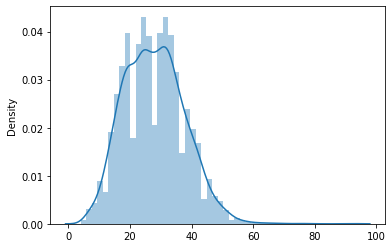

In [14]:
sns.distplot(train_length)

<AxesSubplot:>

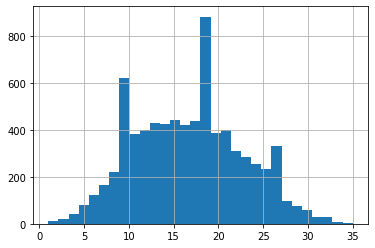

In [15]:
seq_len = [len(i.split()) for i in new_train['new_text']]

pd.Series(seq_len).hist(bins = 30)

In [16]:
MAX_LEN = 50

### Distribution of disaster to non-disaster tweets

In [17]:
labels = new_train['target']
print("Number of disaster tweets: " + str(len(train[train['target'] == 1]['target'])))
print("Number of non-disaster tweets: " + str(len(train[train['target'] == 0]['target'])))
print("Percentage of disaster to non-disaster tweets: " + str(round(len(train[train['target'] == 1]['target']) / len(train['target']), 2)))

Number of disaster tweets: 3271
Number of non-disaster tweets: 4342
Percentage of disaster to non-disaster tweets: 0.43


### Split train dataset into train, validation and test sets

In [18]:
train_text, temp_text, train_labels, temp_labels = train_test_split(train['new_text'], 
                                                                    train['target'], 
                                                                    random_state=2022, 
                                                                    test_size=0.3, 
                                                                    stratify=train['target'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2022, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [19]:
print("Shape of training data:", str(train_text.shape))
print("Shape of validation data:", str(val_text.shape))
print("Shape of test data:", str(test_text.shape))

Shape of training data: (5329,)
Shape of validation data: (1142,)
Shape of test data: (1142,)


In [20]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LEN,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LEN,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LEN,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

C:\Users\Doubl\Desktop\Projects\nlp\disaster_tweets\lib\site-packages\transformers\tokenization_utils_base.py:2226: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [21]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [22]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 16

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [23]:
bert = AutoModel.from_pretrained('bert-base-uncased')

# bert = BertForSequenceClassification.from_pretrained(
#     'bert-base-uncased',
#     num_labels = 2,
#     output_attentions = False,
#     output_hidden_states = False
# )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
for param in bert.parameters():
    param.requires_grad = False

In [25]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):

        super(BERT_Arch, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict = False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

In [26]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3, eps = 1e-8)

In [27]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight = 'balanced', 
                                 classes = np.unique(train_labels), 
                                 y = train_labels)

print(class_wts)

[0.87676867 1.16353712]


In [28]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# # number of training epochs
# epochs = 5

from transformers import get_linear_schedule_with_warmup

epochs = 30
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0, # default value in run glue.py
    num_training_steps = total_steps
)

In [29]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [30]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds = elapsed_rounded))

In [31]:
SEED = 2022
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [32]:
def train():
    t0 = time.time()
    total_loss, total_accuracy = 0, 0
    train_accuracy, nb_train_steps = 0, 0
    
    model.train()

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 100 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print("Batch {:>5,} of {:>5,}. Elapsed: {:}".format(step, len(train_dataloader), elapsed))

        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        model.zero_grad()        

        preds = model(sent_id, mask)
#         preds = model(sent_id, token_type_ids = None, attention_mask = mask, labels = labels)
        
#         loss = preds[0]
    
        logits = preds
        logits = logits.detach().cpu().numpy()
        
        label_ids = labels.to('cpu').numpy()
        tmp_train_accuracy = flat_accuracy(logits, label_ids)
        train_accuracy += tmp_train_accuracy

        loss = cross_entropy(preds, labels)
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step
        
        preds=preds.detach().cpu().numpy()
        total_preds.append(preds)
        
        nb_train_steps += 1
        
    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
    total_preds  = np.concatenate(total_preds, axis=0)
    
    accuracy = train_accuracy / nb_train_steps
    
    print("")
    print("Training Accuracy: {0:.5f}".format(accuracy))
    print("Average training loss: {0:.5f}".format(avg_loss))
    print("Training epoch took: {:}".format(format_time(time.time() - t0)))

    #returns the loss and predictions
    return avg_loss, accuracy, total_preds

In [33]:
def evaluate():
  
    print("\nEvaluating...")

    t0 = time.time()
    
    model.eval()
    
    eval_accuracy, nb_eval_steps = 0, 0
    total_loss, total_accuracy = 0, 0
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):

#         # Progress update every 50 batches.
#         if step % 50 == 0 and not step == 0:

#             # Calculate elapsed time in minutes.
# #             elapsed = format_time(time.time() - t0)

#             # Report progress.
#             print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)
            
            logits = preds
            logits = logits.detach().cpu().numpy()

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)
            
        label_ids = labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        
        nb_eval_steps += 1
    
    accuracy = eval_accuracy / nb_eval_steps
    print("Validation Accuracy: {0:.5f}".format(accuracy))
    print("Validation took: {:}".format(format_time(time.time() - t0)))
    
    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, accuracy, total_preds

In [34]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_acc = []
val_acc = []
train_losses = []
valid_losses = []

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, train_accuracy, _ = train()
    
    #evaluate model
    valid_loss, val_accuracy, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_acc.append(train_accuracy)
    val_acc.append(val_accuracy)
    
#     print(f'\nTraining Loss: {train_loss:.3f}')
#     print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 30
Batch   100 of   334. Elapsed: 0:00:03
Batch   200 of   334. Elapsed: 0:00:05
Batch   300 of   334. Elapsed: 0:00:06

Training Accuracy: 0.64577
Average training loss: 0.64071
Training epoch took: 0:00:07

Evaluating...
Validation Accuracy: 0.74219
Validation took: 0:00:01

 Epoch 2 / 30
Batch   100 of   334. Elapsed: 0:00:02
Batch   200 of   334. Elapsed: 0:00:03
Batch   300 of   334. Elapsed: 0:00:05

Training Accuracy: 0.69124
Average training loss: 0.58970
Training epoch took: 0:00:06

Evaluating...
Validation Accuracy: 0.74913
Validation took: 0:00:01

 Epoch 3 / 30
Batch   100 of   334. Elapsed: 0:00:02
Batch   200 of   334. Elapsed: 0:00:03
Batch   300 of   334. Elapsed: 0:00:05

Training Accuracy: 0.71725
Average training loss: 0.57679
Training epoch took: 0:00:06

Evaluating...
Validation Accuracy: 0.75000
Validation took: 0:00:01

 Epoch 4 / 30
Batch   100 of   334. Elapsed: 0:00:02
Batch   200 of   334. Elapsed: 0:00:03
Batch   300 of   334. Elapsed: 0:00:05



Batch   300 of   334. Elapsed: 0:00:05

Training Accuracy: 0.76179
Average training loss: 0.50103
Training epoch took: 0:00:06

Evaluating...
Validation Accuracy: 0.76534
Validation took: 0:00:01

 Epoch 30 / 30
Batch   100 of   334. Elapsed: 0:00:02
Batch   200 of   334. Elapsed: 0:00:03
Batch   300 of   334. Elapsed: 0:00:05

Training Accuracy: 0.77096
Average training loss: 0.49607
Training epoch took: 0:00:06

Evaluating...
Validation Accuracy: 0.77778
Validation took: 0:00:01


In [35]:
r_dict = {
    "train_accuracy": train_acc,
    "train_loss": train_losses,
    "val_accuracy": val_acc,
    "val_loss": valid_losses,
}

In [36]:
results = pd.DataFrame(r_dict)
results

,train_accuracy,train_loss,val_accuracy,val_loss
0,0.645771,0.640706,0.742188,0.547003
1,0.691243,0.589701,0.749132,0.520549
2,0.717253,0.576791,0.750000,0.516553
3,0.726796,0.553628,0.768229,0.522814
4,0.728855,0.544772,0.709491,0.530353
5,0.730539,0.544395,0.771412,0.545599
6,0.740457,0.534210,0.721644,0.515597
7,0.749813,0.520910,0.765625,0.495558
8,0.749439,0.512579,0.780961,0.509232
9,0.752807,0.524265,0.704282,0.529129
